In [1]:
import pandas
from matplotlib import pyplot as plt
import numpy
import dateutil

Read in the file that Kazu dumped from the SQL database:

In [2]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def make_int(text):
    return int(text.strip('" '))

In [3]:
df = pandas.read_csv('run_meta_info.txt',sep='|',
                     names = ['run', 'config_id', 'numfile', 'start', 'stop', 'length'],
                     converters = { 'run' : make_int, 'config_id' : make_int },
                     skiprows=2)

For future reference, Kazu shares his command to create this database:

SELECT RunNumber AS RUN, MIN(CONFIGID) AS CFG, COUNT(SubRunNumber) AS NUMFILE, MIN(TIMESTART) AS START, MAX(TIMESTOP) AS STOP, MAX(TIMESTOP) - MIN(TIMESTART) AS RUNLENGTH FROM MainRun GROUP BY RunNumber ORDER BY RUnNumber DESC LIMIT 100;

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 6 columns):
run          6000 non-null int64
config_id    6000 non-null int64
numfile      6000 non-null int64
start        6000 non-null object
stop         6000 non-null object
length       6000 non-null object
dtypes: int64(3), object(3)
memory usage: 328.1+ KB


Parse the date columns as actual dates:

In [5]:
df['start'] = df['start'].astype('datetime64[ns]')
df['stop'] = df['stop'].astype('datetime64[ns]')

Make a function to compute the run length for each run, and catch situations where start or stop is not filled in:

In [6]:
def get_exit_code(s):
    """
    Exit codes:
      0 == Normal
      1 == Start time only
      2 == Neither Start nor stop
    """
    # When the date is empty, it's set to be in 1970 (start of epoch)
    # So, it's easy to tell when things are empty
    if s['start'].year < 2000:
        return 2
    if s['stop'].year < 2000:
        return 1
    return 0

In [7]:
# Do some parsing to figure out which runs completed, which crashed on configuration, etc
df['exit'] = df.apply(get_exit_code, axis=1)


Make a data frame to handle run statistics:

In [8]:
def compute_length(s):
    return (s['stop'] - s['start']).total_seconds() / 60.

In [9]:
#Get a list of the unique config ids with at least one run that stopped:
unique_ids, counts = numpy.unique(df['config_id'], return_counts=True)

run_df = pandas.DataFrame(index=unique_ids, columns=["average_run_length", "N_total_runs", "N_non_zero_runs",
                                                     "N_crash_on_config", "run_lengths" ])

# Fill in the number of runs:
for _id, count in zip(unique_ids, counts):
    run_df.loc[_id,'N_total_runs'] = count
    run_df.loc[_id,'N_non_zero_runs'] = len(df.query("config_id == {} and exit == 0".format(_id)).index)
    run_df.loc[_id,'N_crash_on_config'] = len(df.query("config_id == {} and exit != 0".format(_id)).index)

# Fill in the average run length (only runs that stopped):
for _id in unique_ids:
    if run_df.loc[_id,"N_non_zero_runs"] > 0:
        _sub_df = df.query("config_id == {} and exit == 0".format(_id))
        lengths = numpy.asarray(_sub_df.apply(compute_length, axis=1))
        run_df.loc[_id,"average_run_length"] = numpy.average(lengths)
        run_df.loc[_id,"run_lengths"] = lengths
    

Make a histogram of run times, broken out by config ID:

In [10]:
# Only select configs with at least N completed runs:
def plot_config_average_lengths(run_df, min_N):
    config_ids = run_df.query("N_non_zero_runs > {}".format(int(min_N))).index.values
    lengths = run_df.query("N_non_zero_runs > {}".format(int(min_N)))['average_run_length']
    fig, ax = plt.subplots(figsize=(16,9))
    
    width = 0.75
    ind = numpy.arange(0,len(config_ids),1)
    rects = ax.bar(ind + 0.5*width, lengths, width=width, label="Average Run Length")

    # Set the boundaries nicely:
    ax.set_xlim([0, len(ind)])
    plt.xticks(ind + width, config_ids)
    plt.grid(True)
    plt.xlabel("Run Config ID", fontsize=20)
    plt.ylabel("Average Run Length [Minutes]",fontsize=20)
    plt.legend(fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                tick.label.set_rotation('vertical')
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    plt.show()

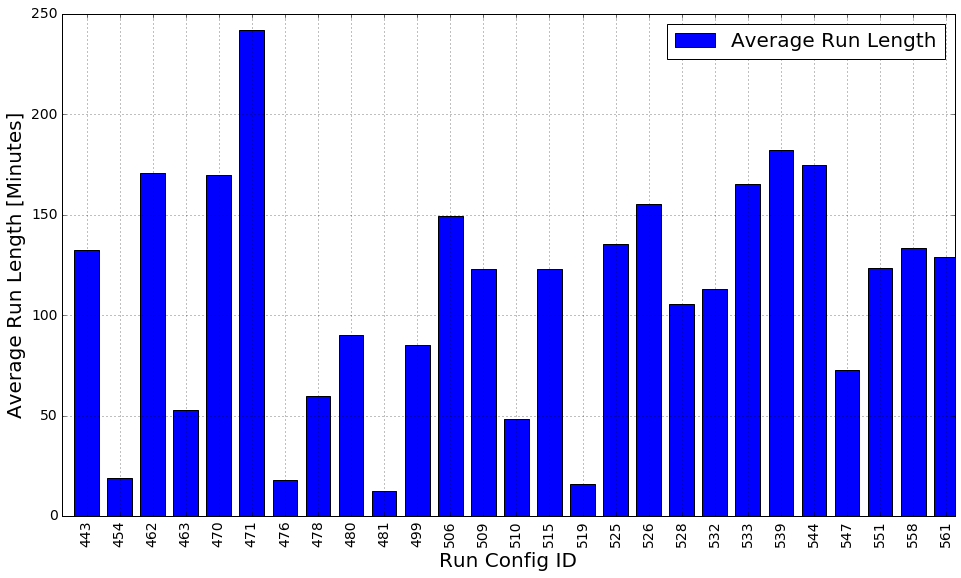

In [11]:
plot_config_average_lengths(run_df, 25)


In [12]:
def plot_run_lengths(run_df, config_id, extra_text = None):
    fig, ax = plt.subplots(figsize=(16,9))
    bins = numpy.arange(0,441, 20)
    dist, bin_edges = numpy.histogram(run_df.loc[config_id]['run_lengths'], bins=bins, normed=True)
    dist *= 100.0/numpy.sum(dist)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
    bin_widths = 0.5*(bin_edges[1:] - bin_edges[0:-1])
    rects = ax.bar(bin_edges[0:-1], dist, width=2*bin_widths, label="Run Lengths, Confid {}".format(config_id))
    plt.grid(True)
    plt.ylim([0,50])
    plt.xlabel("Run Time [Minutes]", fontsize=20)
    plt.ylabel("Percent of Runs",fontsize=20)
    if extra_text is not None:
        ax.text(210, 25, extra_text, fontsize=20)
    plt.legend(fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    plt.show()

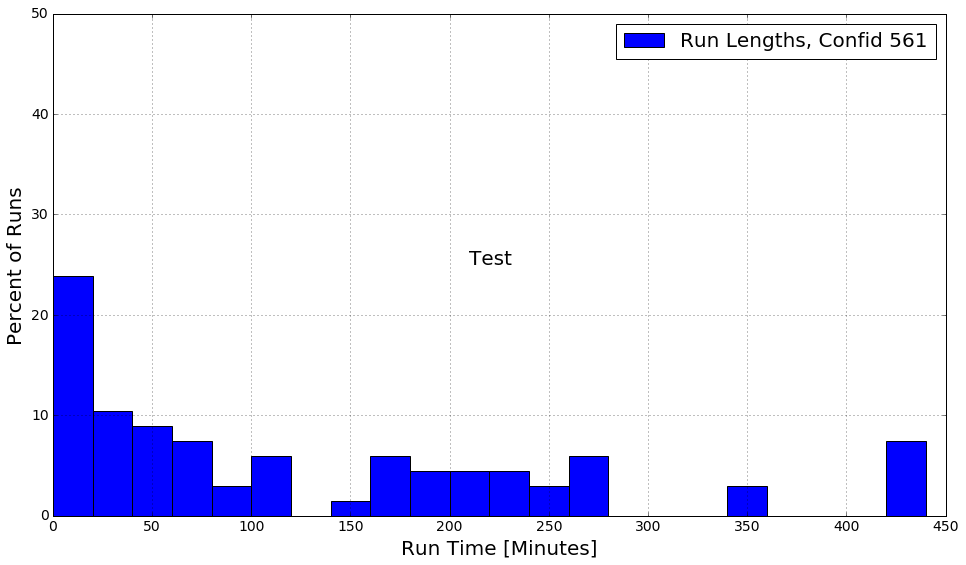

In [13]:
plot_run_lengths(run_df, 561, "Test")



That is working well.  This is an enumeration of the interesting configs:

In [14]:
config_name = dict()
config_name.update({561: "Recent Runs, 3 Hz Ext."}) # PHYSICS_BNB_NUMI_MUCS_EXT3000mHz_SWTrigger_2Stream_c22
config_name.update({558: "Recent Runs, 10Hz Ext"}) # PHYSICS_BNB_NUMI_MUCS_EXT9990mHz_SWTrigger_2Stream_c22
config_name.update({462: "Pre Shutdown 2016, 5Hz Ext"}) # PHYSICS_BNB_NUMI_MUCS_EXT5Hz_SWTrigger_c0, pre-shutdown 2016
# config_name.update({462: "Post Shutdown 2016, 5Hz Ext"}) # PHYSICS_BNB_NUMI_MUCS_EXT5Hz_SWTrigger_c0
config_name.update({509: "Post Shutdown 2016, 10Hz Ext"}) # PHYSICS_BNB_NUMI_MUCS_EXT10Hz_SWTrigger_c0
config_name.update({515: "Post Shutdown 2016, unknown"})

[561, 515, 462, 558, 509]


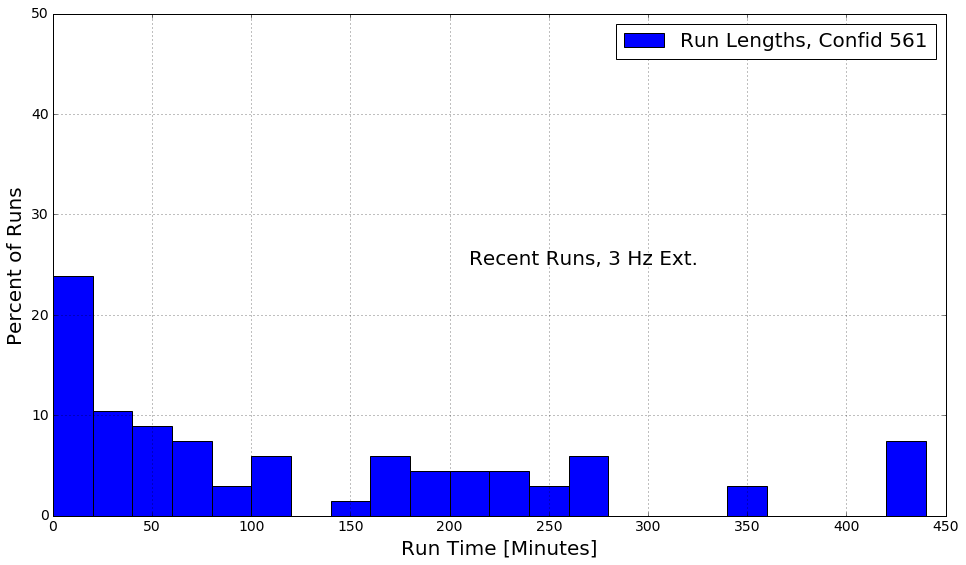

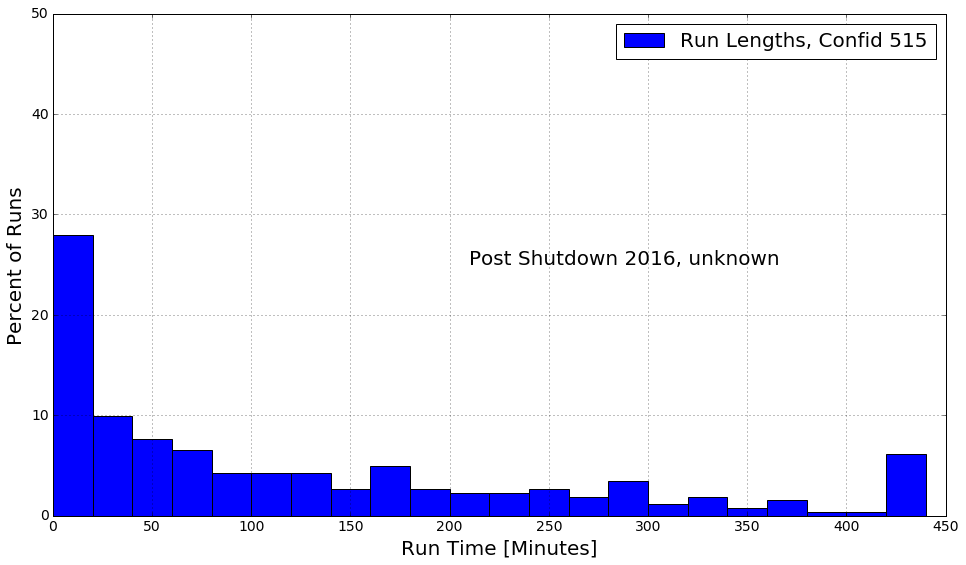

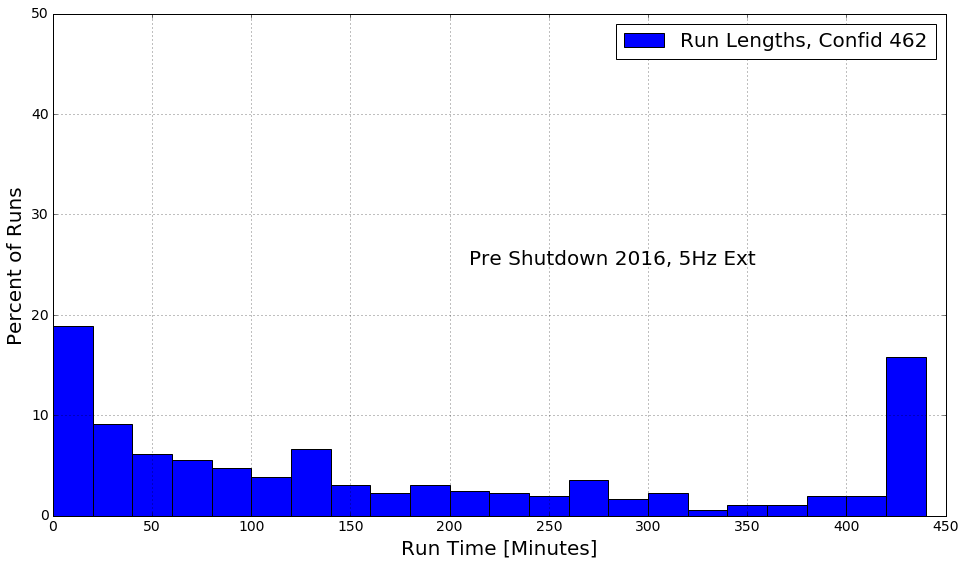

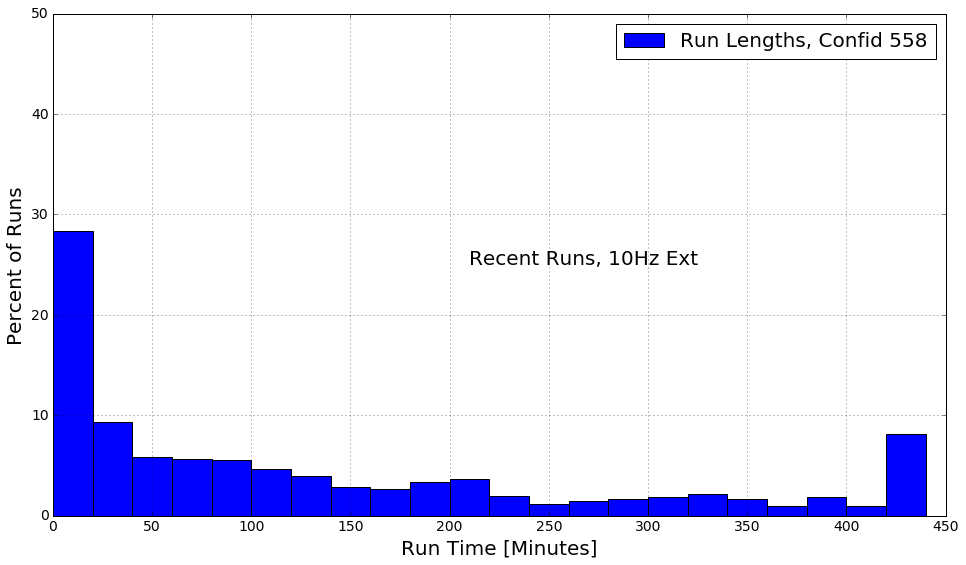

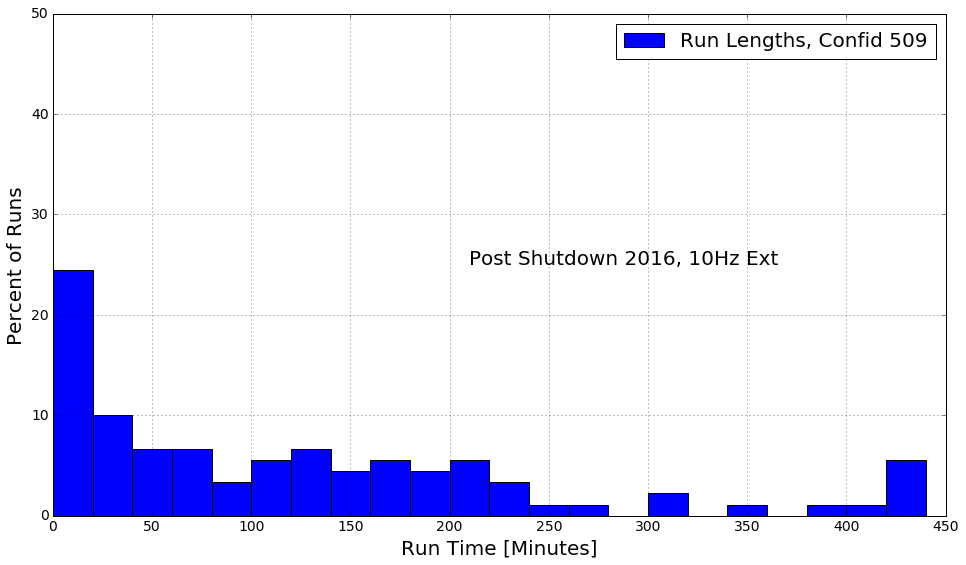

In [15]:
print config_name.keys()
for key in config_name.keys():
    plot_run_lengths(run_df, key, config_name[key])

In [16]:
# Only select configs with at least N attempted runs:
def plot_config_fail_rate(run_df, min_N):
    config_ids = run_df.query("N_total_runs > {}".format(int(min_N))).index.values
    attempts = numpy.asarray(run_df.loc[config_ids,"N_total_runs"])
    successes = numpy.asarray(run_df.loc[config_ids,"N_non_zero_runs"])
    fails = attempts - successes

    success_rate = (1.0 * successes) / attempts
    fail_rate = (1.0 - success_rate)
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    width = 0.75
    ind = numpy.arange(0,len(config_ids),1)
    _pass = ax.bar(ind + 0.5*width, successes,
                   width=width, 
                   color='g',
                   label="Started Runs")
    _fail = ax.bar(ind + 0.5*width, fails,
                   bottom=successes,
                   width=width, 
                   color='r',
                   label="Crashed @ Config Runs")

    # Set the boundaries nicely:
    ax.set_xlim([0, len(ind)])
    plt.xticks(ind + width, config_ids)
    plt.grid(True)
    plt.xlabel("Run Config ID (Fail Rate @ config on top)", fontsize=20)
    plt.ylabel("Average Run Length [Minutes]",fontsize=20)
    plt.legend(fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                tick.label.set_rotation('vertical')
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
            

    # Add labels to show the fail rate:
    i = 0
    for p, f in zip(_pass, _fail):
        height = p.get_height() + f.get_height()
        x = p.get_x() + p.get_width()/2
        ax.text(x, height + 10,
                '%d' % int(100*fail_rate[i]),
                ha='center', va='bottom', fontsize=12)
        i += 1

    plt.show()

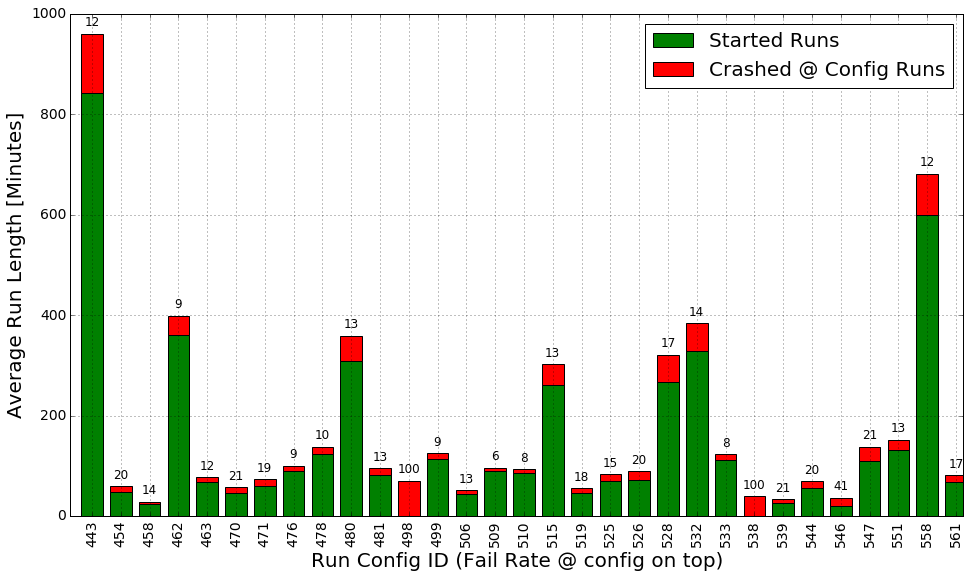

In [17]:
plot_config_fail_rate(run_df, 25)

In [56]:
# Only select configs with at least N attempted runs:
def plot_config_finish_rate(run_df, min_N):
    config_ids = run_df.query("N_non_zero_runs > {}".format(int(min_N))).index.values
    attempts = numpy.asarray(run_df.loc[config_ids,"N_non_zero_runs"])
    
    finish_rate = numpy.zeros(len(config_ids))
    i = 0
    for _id in config_ids:
        lengths = run_df.loc[_id]['run_lengths']
        successes = numpy.sum(lengths > 419)
        finish_rate[i]= (1.0*successes) / attempts[i]
        i+= 1
        
    fail_rate = (1.0 - finish_rate)
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    width = 0.75
    ind = numpy.arange(0,len(config_ids),1)
    _pass = ax.bar(ind + 0.5*width, 100*finish_rate,
                   width=width, 
                   color='g',
                   label="Started Runs")
#     _fail = ax.bar(ind + 0.5*width, fail_rate,
#                    bottom=finish_rate,
#                    width=width, 
#                    color='r',
#                    label="Crashed @ Config Runs")

    # Set the boundaries nicely:
    ax.set_xlim([0, len(ind)])
    plt.xticks(ind + width, config_ids)
    plt.grid(True)
    plt.xlabel("Run Config ID", fontsize=20)
    plt.ylabel("Percentage of Finished Runs",fontsize=20)
    plt.legend(fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                tick.label.set_rotation('vertical')
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
            

#     # Add labels to show the fail rate:
#     i = 0
#     for p, f in zip(finish_rate, fail_rate):
#         height = p.get_height() + f.get_height()
#         x = p.get_x() + p.get_width()/2
#         ax.text(x, height + 10,
#                 '%d' % int(100*finish_rate[i]),
#                 ha='center', va='bottom', fontsize=12)
#         i += 1

    plt.show()

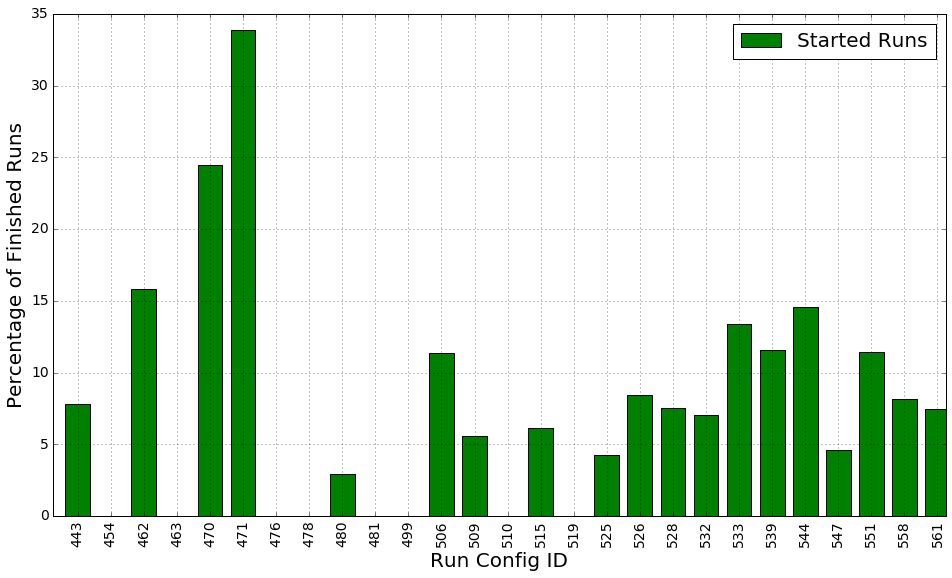

In [57]:
plot_config_finish_rate(run_df, 25)